In [1]:
%cd ../src/

/mnt/c/Users/Jacob/Desktop/prosjektoppgave/tcav_atari/src


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from concepts import concept_instances
from sk_probing import train_probe
from utils import load_game_data, load_q_network_device, prepare_folders

In [3]:
game_data = load_game_data()

max_data_size = 1000
max_iter = 200
k_fold = 5
num_reg = 5
layer = 5

In [4]:
q_network, device = load_q_network_device()
q_network.to('cpu')

QNetwork(
  (network): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=3136, out_features=512, bias=True)
    (8): ReLU()
    (9): Linear(in_features=512, out_features=4, bias=True)
  )
)

In [5]:
ball_low = concept_instances['ball low (b)']
ball_left = concept_instances['ball left for paddle (b)']
brick_hit = concept_instances['brick hit (b)']
paddle_right = concept_instances['paddle x']
bricks_hit = concept_instances['bricks hit']

ball_low.prepare_data(game_data, max_size=max_data_size)
ball_left.prepare_data(game_data, max_size=max_data_size)
brick_hit.prepare_data(game_data, max_size=max_data_size)
paddle_right.prepare_data(game_data, max_size=max_data_size)
bricks_hit.prepare_data(game_data, max_size=max_data_size)

In [6]:
ball_low_probe, ball_low_score = train_probe(q_network, ball_low, layer=layer, max_iter=max_iter, k_fold=k_fold, num_reg=num_reg)
ball_left_probe, ball_left_score = train_probe(q_network, ball_left, layer=layer, max_iter=max_iter, k_fold=k_fold, num_reg=num_reg)
brick_hit_probe, brick_hit_score = train_probe(q_network, brick_hit, layer=layer, max_iter=max_iter, k_fold=k_fold, num_reg=num_reg)
paddle_right_probe, paddle_right_score = train_probe(q_network, paddle_right, layer=layer, max_iter=max_iter, k_fold=k_fold, num_reg=num_reg)
bricks_hit_probe, bricks_hit_score = train_probe(q_network, bricks_hit, layer=layer, max_iter=max_iter, k_fold=k_fold, num_reg=num_reg)

In [7]:
def cosine_similarity(v1, v2):
    dot_product = np.dot(v1, v2)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    return dot_product / (norm_v1 * norm_v2)

In [8]:
# sort images by activations and cav
def sort(images, acts, coefficients, best_first=True):
    cav = coefficients
    # sort images by cosine similarity of activations and cav
    images_acts = list(zip(images, acts))
    images_acts.sort(key=lambda x: cosine_similarity(x[1], cav), reverse=best_first)
    images, acts = zip(*images_acts)
    #for i in range(10):
    #    print(round(cosine_similarity(acts[i], cav),3), end=' ')
    #print()
    return images

In [9]:
def plot_images(images, n):
    # Determine the number of rows required for every 3 images per row
    rows = -(-n // 3)
    fig = plt.figure(figsize=(12, 5 * rows))
    for i in range(n):
        ax = fig.add_subplot(rows, 3, i+1)
        ax.imshow(images[i])
        ax.axis('off')
    plt.show()

In [10]:
def sort_images(concept, coefficients, best_first=True):
    images = concept.test_images
    _, test_acts_dict = q_network(torch.tensor(concept.test_obs), return_acts=True)
    test_acts = test_acts_dict[str(layer)].cpu().detach().numpy()
    test_acts = test_acts.reshape(len(test_acts), -1)
    images = sort(images, test_acts, coefficients, best_first)
    plot_images(images, 6)

In [11]:
def get_coeffs(concept, probe):
    if concept.binary:
        coeffs = probe.coef_[0]
    else:
        coeffs = probe.coef_
    return coeffs

### Ball low

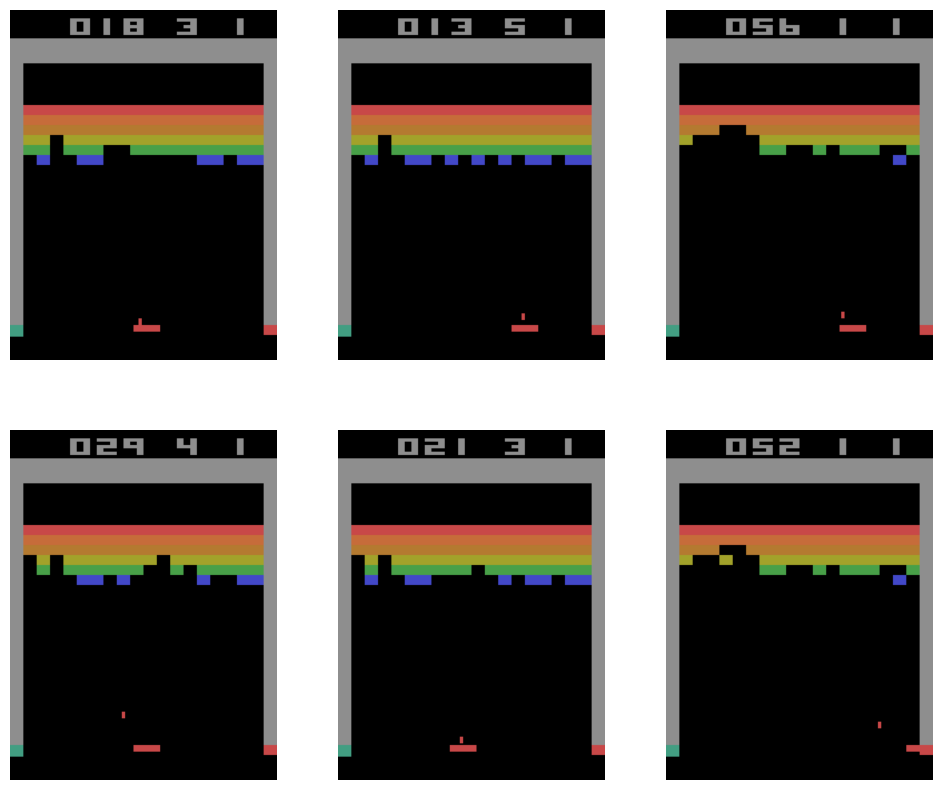

In [12]:
ball_low_coef = get_coeffs(ball_low, ball_low_probe)
sort_images(ball_low, ball_low_coef, best_first=True)

### Ball Left for paddle

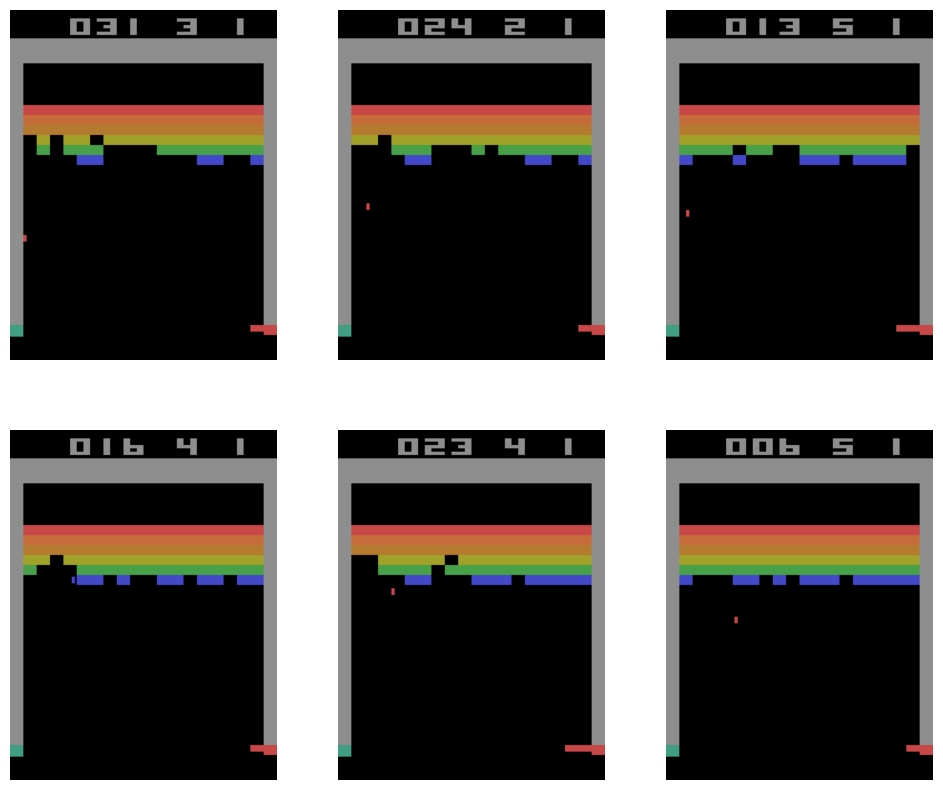

In [13]:
ball_left_coef = get_coeffs(ball_left, ball_left_probe)
sort_images(ball_left, ball_left_coef, best_first=True)

### Brick hit

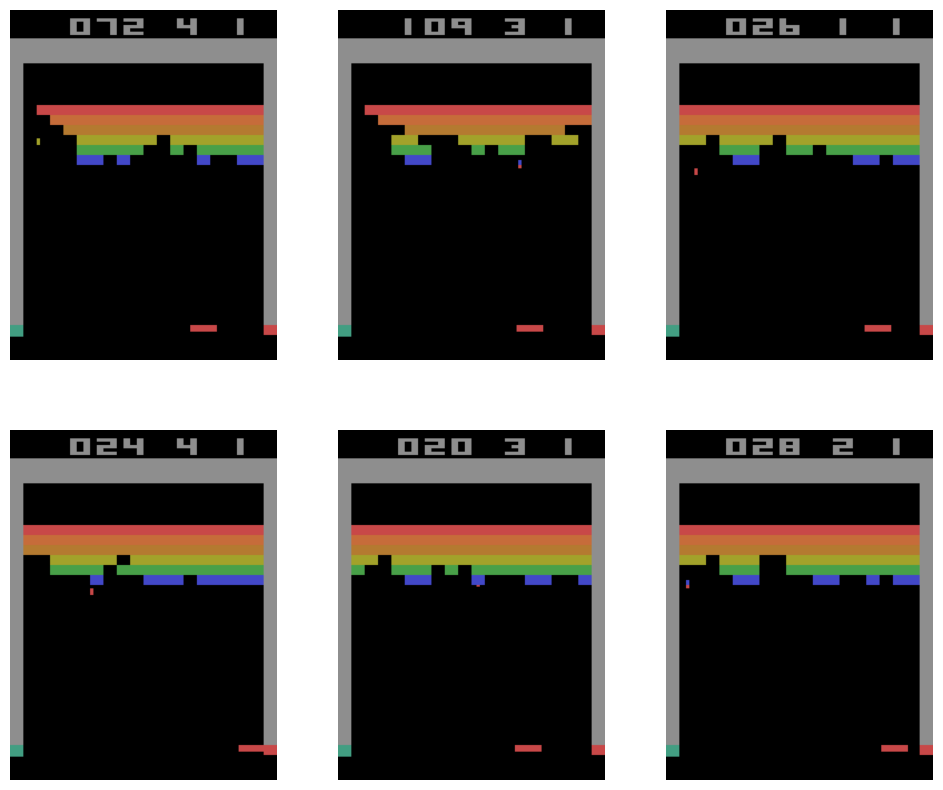

In [14]:
brick_hit_coef = get_coeffs(brick_hit, brick_hit_probe)
sort_images(brick_hit, brick_hit_coef, best_first=True)

### Paddle right (non binary)

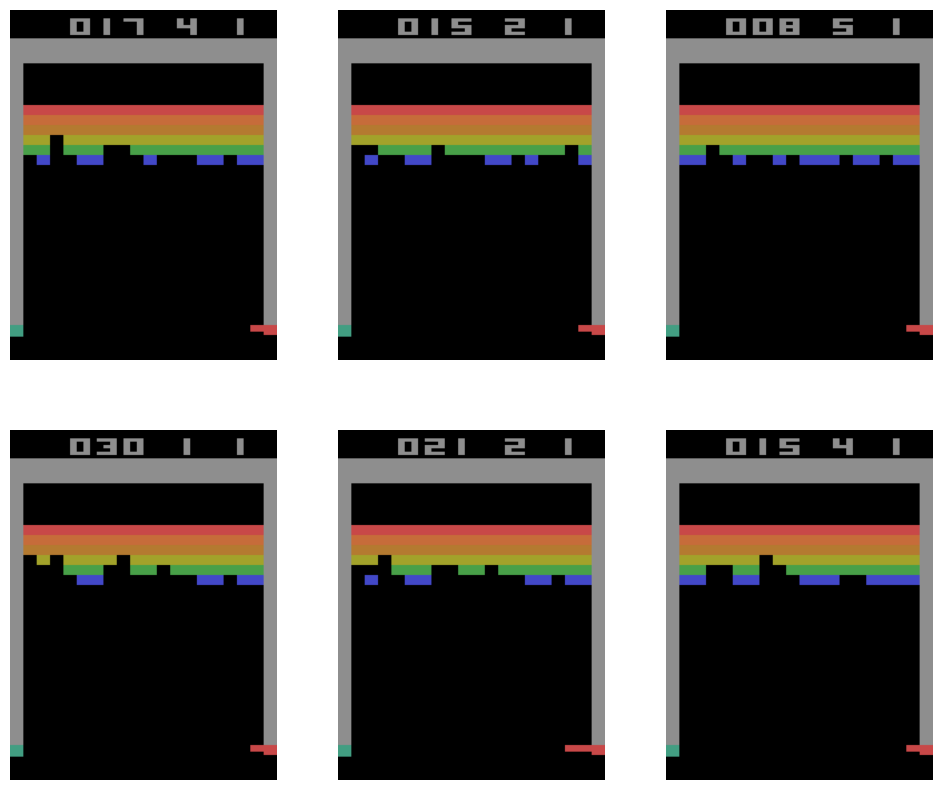

In [15]:
paddle_right_coef = get_coeffs(paddle_right, paddle_right_probe)
sort_images(paddle_right, paddle_right_coef, best_first=True)

### Bricks hit (non binary)

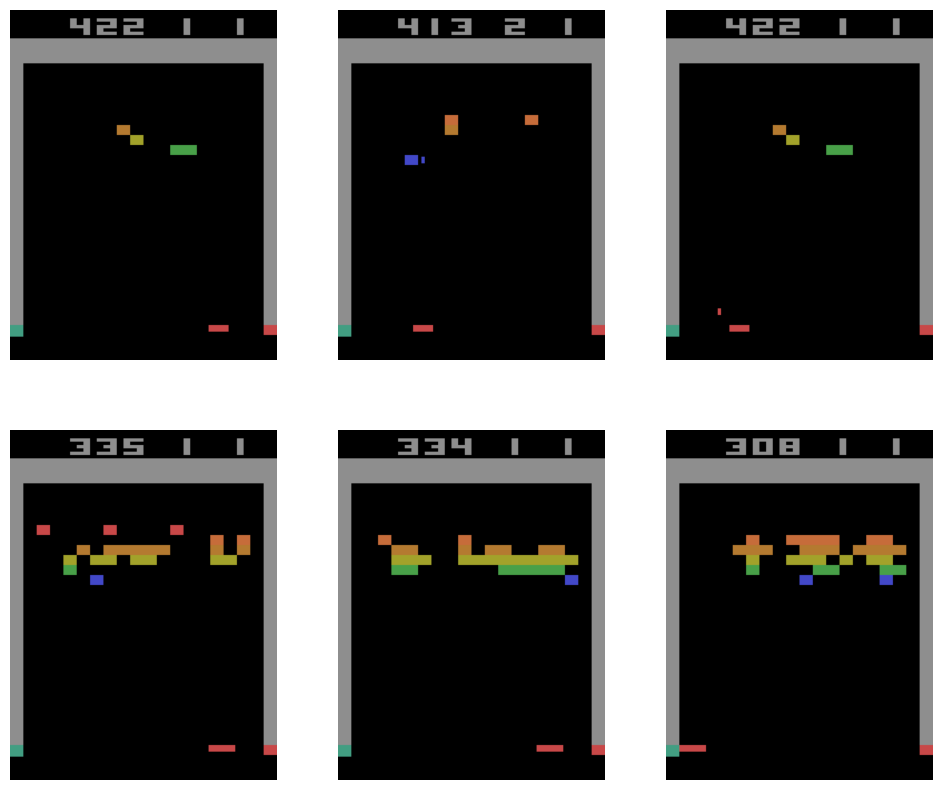

In [16]:
bricks_hit_coef = get_coeffs(bricks_hit, bricks_hit_probe)
sort_images(bricks_hit, bricks_hit_coef, best_first=True)

### Ball left - Ball low

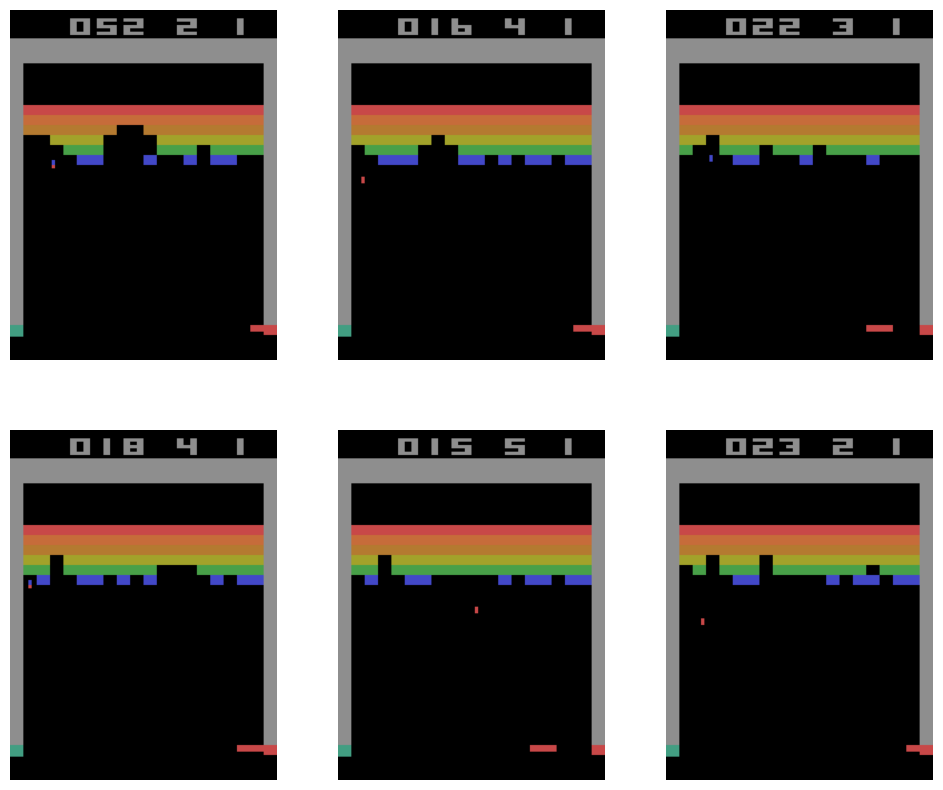

In [17]:
sort_images(ball_low, ball_left_coef - ball_low_coef, best_first=True)

### Ball left - Ball low + Brick hit

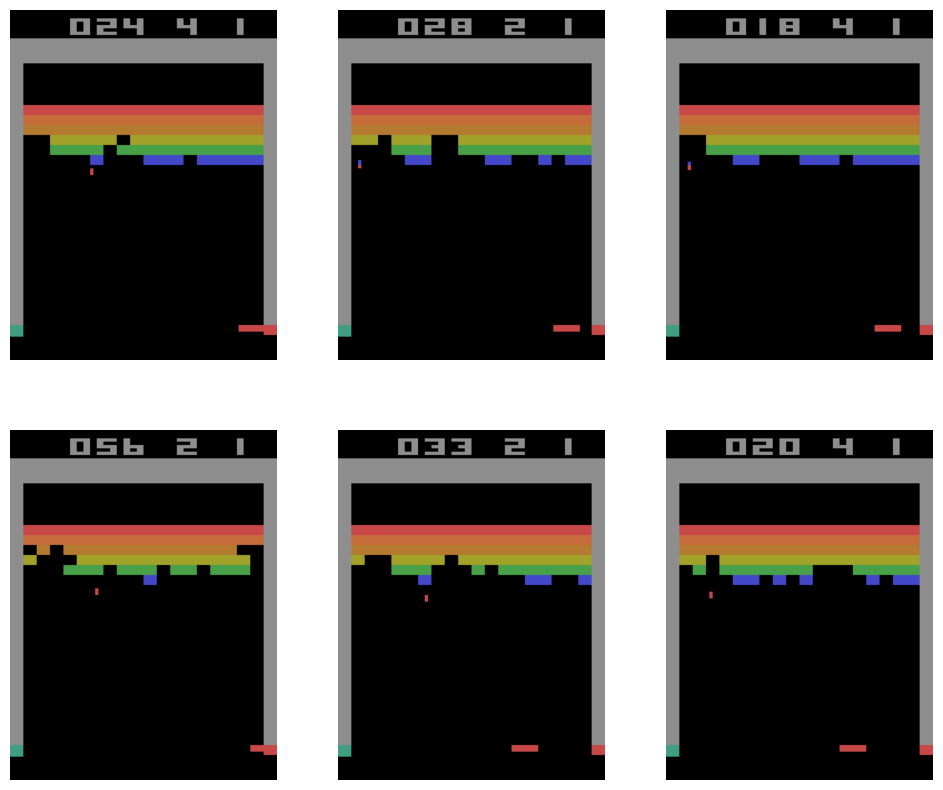

In [18]:
sort_images(brick_hit, ball_left_coef - ball_low_coef + brick_hit_coef, best_first=True)

### Ball left - Ball low - Brick hit

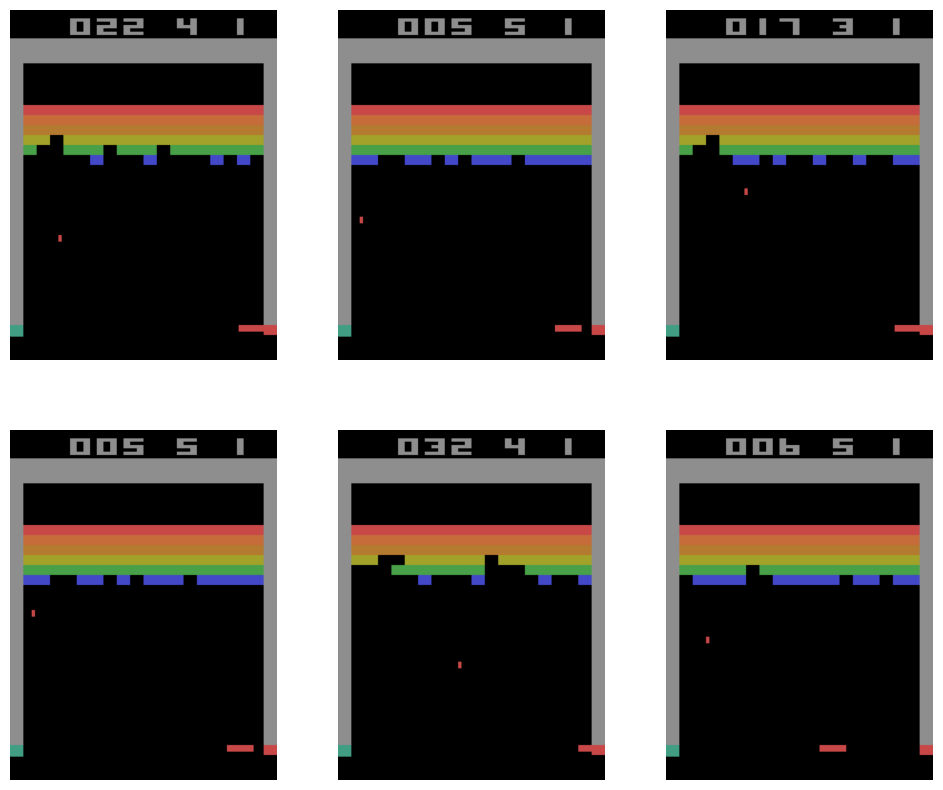

In [19]:
sort_images(brick_hit, ball_left_coef - ball_low_coef - brick_hit_coef, best_first=True)

### Bricks hit + paddle right + ball low

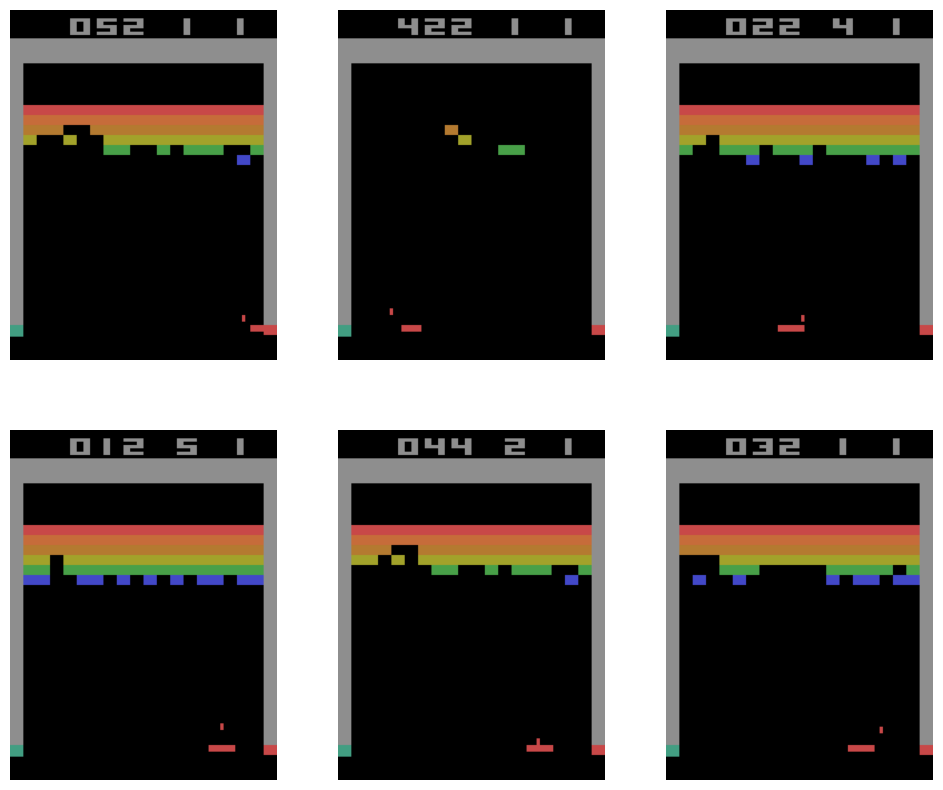

In [20]:
sort_images(bricks_hit, bricks_hit_coef + paddle_right_coef + ball_low_coef, best_first=True)

### Paddle right - bricks hit

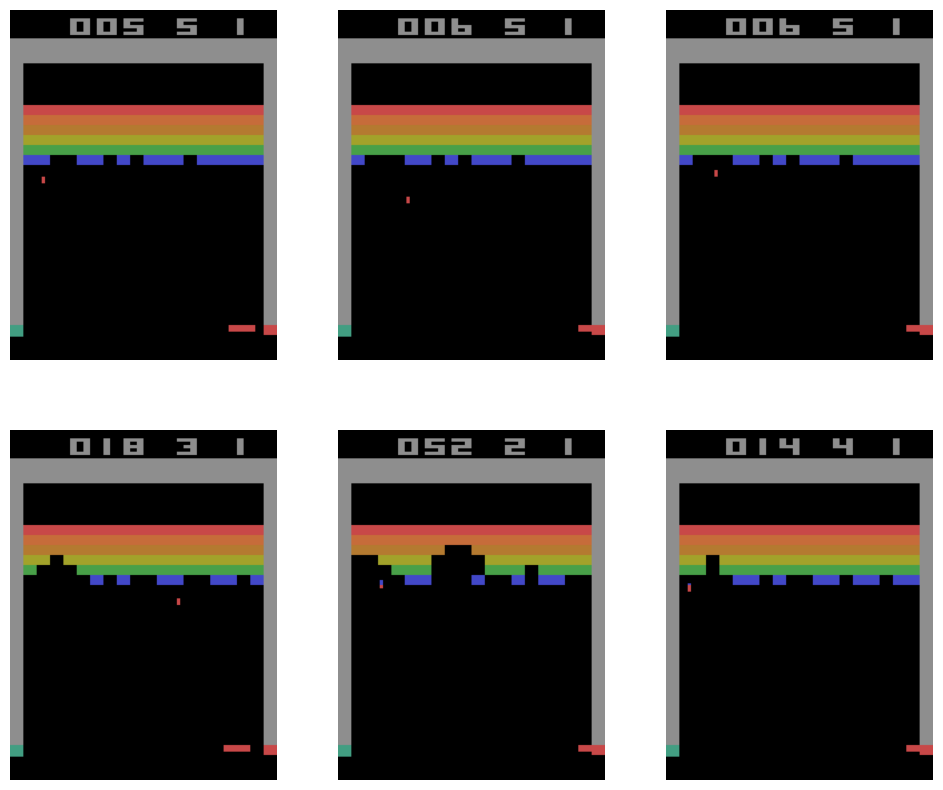

In [21]:
sort_images(bricks_hit, paddle_right_coef - bricks_hit_coef - ball_low_coef, best_first=True)